In [158]:
import pandas as pd
import os
from tqdm import tqdm
from pathlib import Path
from genes import GENES
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Step 1: Collect MAF Files

This function traverses the data directory and collects all files with a `.maf.gz` extension.


In [5]:
data_dir = "./data"
files = []
for root, _, fns in os.walk(data_dir):
    for fn in fns:
        if fn.endswith(".maf.gz"):
            files.append((os.path.join(root, fn), Path(root).name))

print(f"Found {len(files)} MAF files.")


Found 2302 MAF files.


## Step 2: Build Long DataFrame

Filters for genes of interest and computes summary statistics per gene and sample.


In [139]:
recs = []
for fp, case in tqdm(files):
    df = pd.read_csv(fp, sep='\t', comment='#', compression='gzip',
                     usecols=['Hugo_Symbol','Variant_Classification',
                              't_alt_count','t_depth', 'Tumor_Sample_Barcode'])
    df = df[df.Hugo_Symbol.isin(GENES)]

    if df.empty:
        continue

    df['vaf'] = df['t_alt_count'] / df['t_depth']
    grp = df.groupby('Hugo_Symbol').agg(
        n_mut=('Hugo_Symbol','size'),
        t_alt=('t_alt_count','sum'),
        mean_vaf=('vaf', 'mean'),
        worst_class=('Variant_Classification',
                     lambda x: x.mode().iat[0])
    ).reset_index()
    grp['case'] = case
    recs.append(grp)

long_df = pd.concat(recs, ignore_index=True)
long_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 2302/2302 [00:09<00:00, 243.43it/s]


,Hugo_Symbol,n_mut,t_alt,mean_vaf,worst_class,case
0,GATA2,1,81,0.500000,Missense_Mutation,00129ada-3434-4334-a881-3aed765c8765
1,KRAS,1,69,0.118151,Missense_Mutation,00129ada-3434-4334-a881-3aed765c8765
2,NRAS,1,103,0.234624,Missense_Mutation,00129ada-3434-4334-a881-3aed765c8765
3,ABCA5,1,24,0.171429,Missense_Mutation,002278c2-89ad-4ae7-a91c-9a7e9e060e5b
4,ERG,1,12,0.080000,Missense_Mutation,002278c2-89ad-4ae7-a91c-9a7e9e060e5b


## Step 3: Create Feature Matrix

Create a pivot table with `t_alt` and `mean_vaf` values for each gene, per sample.


In [143]:
feat_counts = long_df.pivot(index='case',
                            columns='Hugo_Symbol',
                            values=['t_alt', 'mean_vaf'])\
                     .fillna(0)

feat_counts.columns = [f"{a}_{b}" for a, b in feat_counts.columns]

if not long_df.empty:
    overall_class = long_df.groupby('case')['worst_class'].agg(
        lambda x: x.mode().iat[0] if not x.mode().empty else 'None')
    overall_class.name = 'worst_class_overall'
    X = pd.concat([feat_counts], axis=1)
    X = X.join(overall_class)
else:
    X = feat_counts
    
print(f"Feature matrix shape: {X.shape}")
X.head()

Feature matrix shape: (1656, 809)


,t_alt_AASDH,t_alt_ABCA1,t_alt_ABCA13,t_alt_ABCA5,t_alt_ABCA6,t_alt_ABCC1,t_alt_ACADL,t_alt_ACTC1,t_alt_ADAMTS18,t_alt_ADAMTS19,...,mean_vaf_ZNF415,mean_vaf_ZNF462,mean_vaf_ZNF469,mean_vaf_ZNF516,mean_vaf_ZNF518A,mean_vaf_ZNF521,mean_vaf_ZNF57,mean_vaf_ZNF618,mean_vaf_ZNF804B,worst_class_overall
case,,,,,,,,,,,,,,,,,,,,,
00129ada-3434-4334-a881-3aed765c8765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Missense_Mutation
002278c2-89ad-4ae7-a91c-9a7e9e060e5b,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Missense_Mutation
009c9a3c-f28e-42ce-84ce-452bfa3e764d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Frame_Shift_Ins
009cd332-fda7-4dc2-861a-a16c6fdf9a07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Missense_Mutation
009dd5db-b6a3-475b-815c-0b4904fcb925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3'Flank


## Step 4 Save Feature Matrix


In [146]:
X.to_csv("combined_mutation_matrix.csv")
print("Saved to combined_mutation_matrix.csv")

Saved to combined_mutation_matrix.csv


In [147]:
disease_data = pd.read_csv("disease_ids.csv")
disease_data.head()

,case_id,tumor_code
0,00129ada-3434-4334-a881-3aed765c8765,Acute myeloid leukemia (AML)
1,002278c2-89ad-4ae7-a91c-9a7e9e060e5b,Acute lymphoblastic leukemia (ALL)
2,009c9a3c-f28e-42ce-84ce-452bfa3e764d,Acute myeloid leukemia (AML)
3,009cd332-fda7-4dc2-861a-a16c6fdf9a07,Acute lymphoblastic leukemia (ALL)
4,009dd5db-b6a3-475b-815c-0b4904fcb925,Acute lymphoblastic leukemia (ALL)


In [148]:
df = X.copy()
df['disease_name'] = df.index.map(disease_data.set_index('case_id')['tumor_code'])
df = df.dropna(subset=['disease_name'])
df['group'] = df['disease_name']

def count_abnormalities_per_sample(row):
    return ((row != 0) & (~pd.isna(row))).sum()

columns = df.shape[1] - 4
chromosome_cols = df.columns[1:columns]
df['abnormality_count'] = df[chromosome_cols].apply(count_abnormalities_per_sample, axis=1)

df.head()

,t_alt_AASDH,t_alt_ABCA1,t_alt_ABCA13,t_alt_ABCA5,t_alt_ABCA6,t_alt_ABCC1,t_alt_ACADL,t_alt_ACTC1,t_alt_ADAMTS18,t_alt_ADAMTS19,...,mean_vaf_ZNF516,mean_vaf_ZNF518A,mean_vaf_ZNF521,mean_vaf_ZNF57,mean_vaf_ZNF618,mean_vaf_ZNF804B,worst_class_overall,disease_name,group,abnormality_count
case,,,,,,,,,,,,,,,,,,,,,
00129ada-3434-4334-a881-3aed765c8765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Missense_Mutation,Acute myeloid leukemia (AML),Acute myeloid leukemia (AML),6
002278c2-89ad-4ae7-a91c-9a7e9e060e5b,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Missense_Mutation,Acute lymphoblastic leukemia (ALL),Acute lymphoblastic leukemia (ALL),10
009c9a3c-f28e-42ce-84ce-452bfa3e764d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Frame_Shift_Ins,Acute myeloid leukemia (AML),Acute myeloid leukemia (AML),6
009cd332-fda7-4dc2-861a-a16c6fdf9a07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Missense_Mutation,Acute lymphoblastic leukemia (ALL),Acute lymphoblastic leukemia (ALL),2
009dd5db-b6a3-475b-815c-0b4904fcb925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3'Flank,Acute lymphoblastic leukemia (ALL),Acute lymphoblastic leukemia (ALL),2


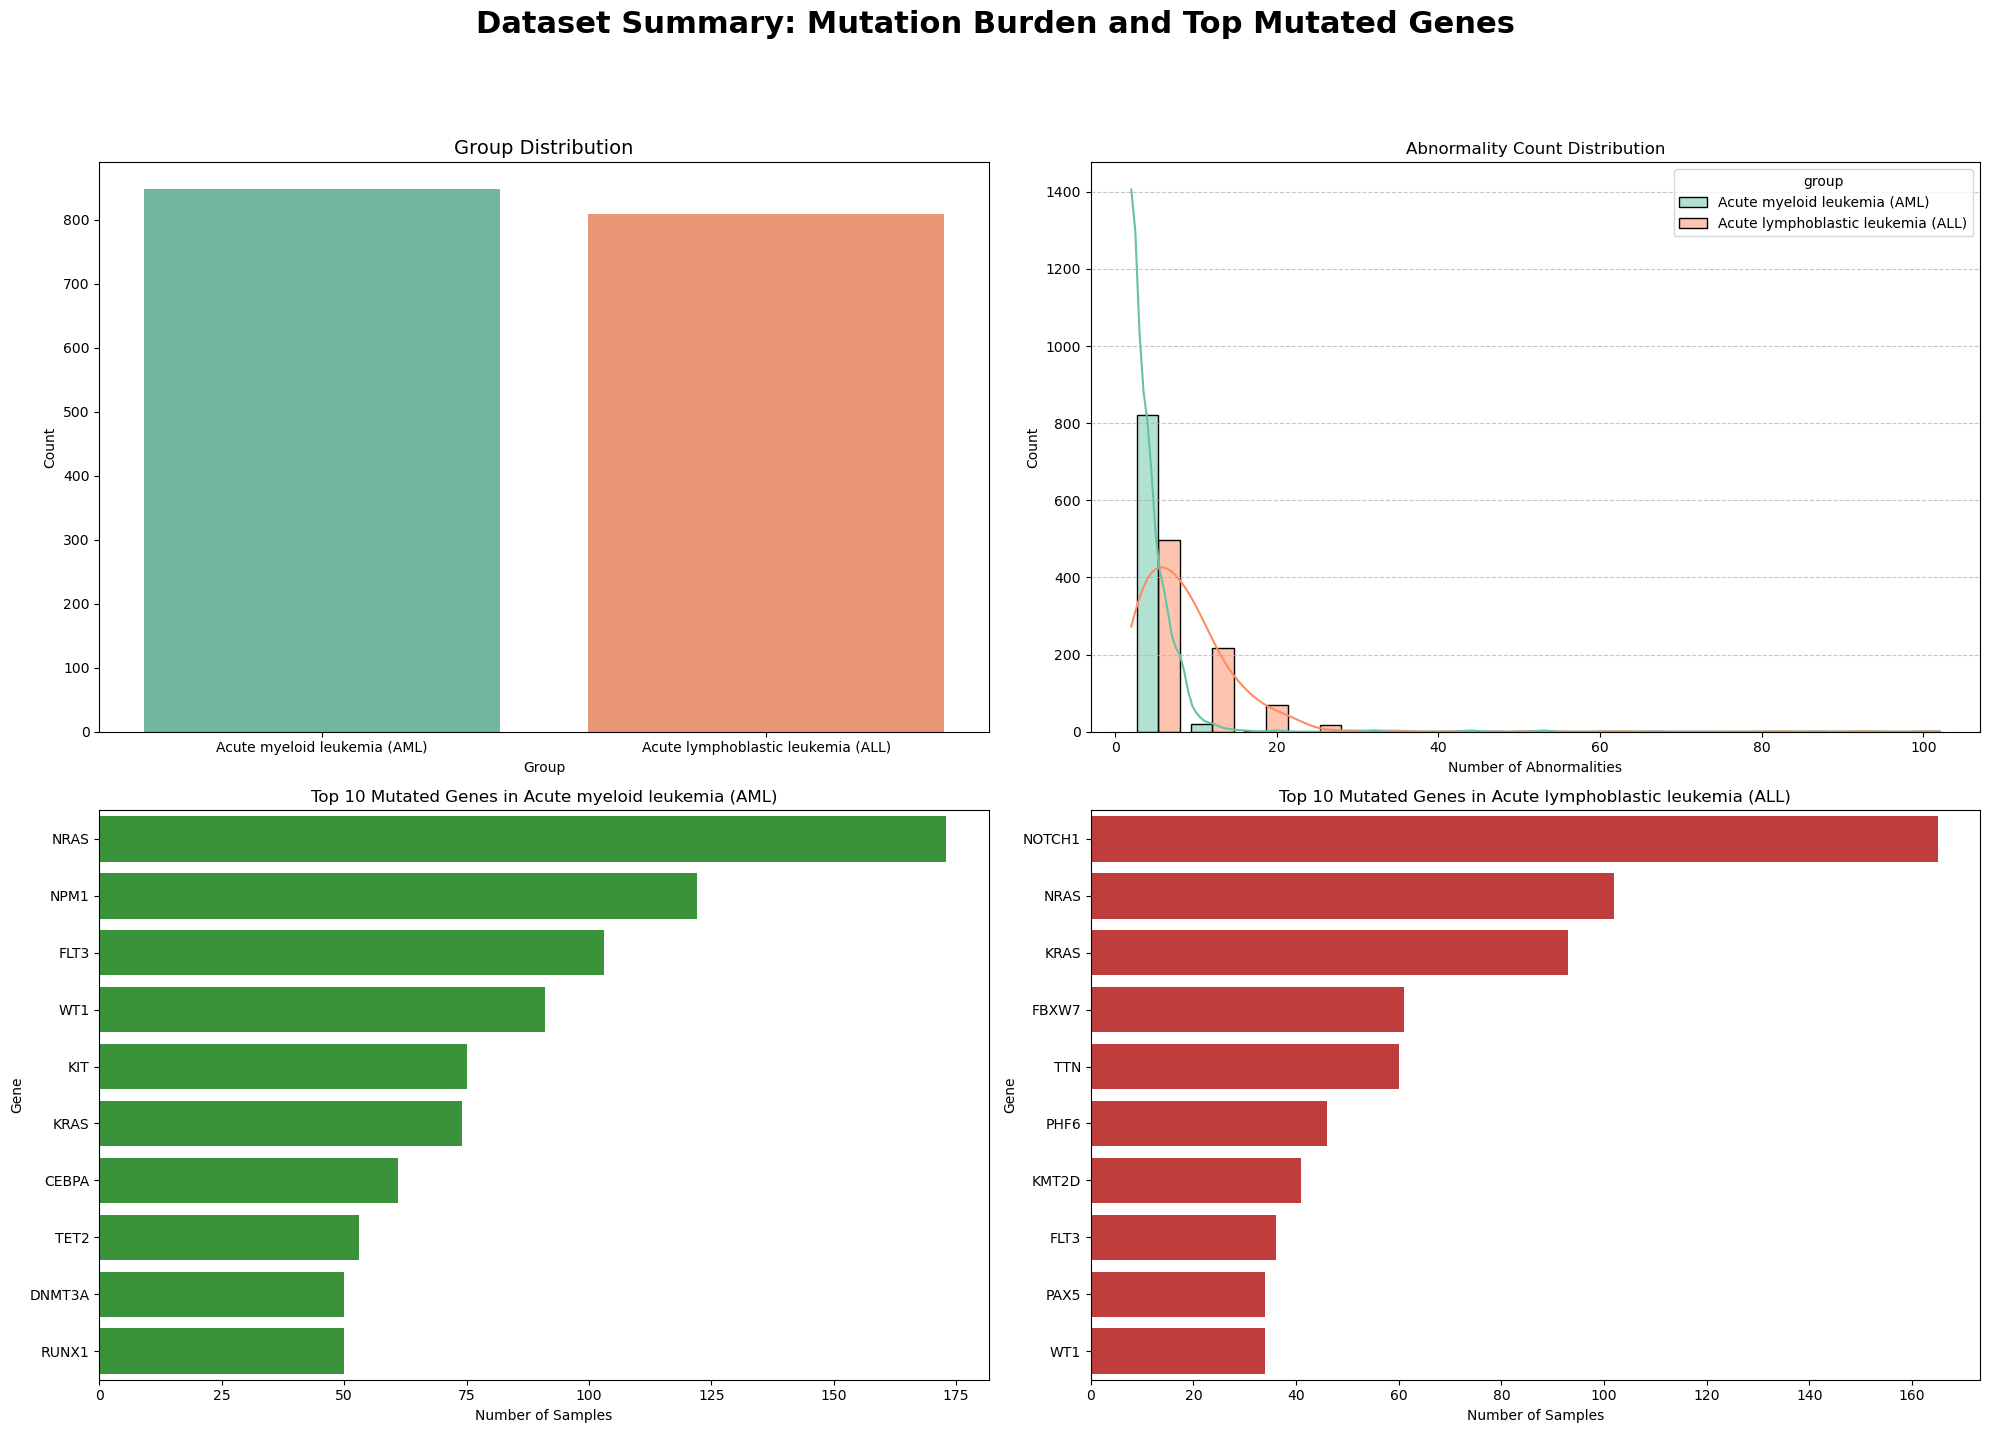

In [153]:
plt.figure(figsize=(20, 14))
gs = GridSpec(2, 2)

ax1 = plt.subplot(gs[0, 0])
sns.countplot(x='group', data=df, ax=ax1, palette='Set2')
ax1.set_title('Group Distribution', fontsize=14)
ax1.set_xlabel('Group')
ax1.set_ylabel('Count')

ax2 = plt.subplot(gs[0, 1])
sns.histplot(data=df, x='abnormality_count', hue='group', bins=15, multiple='dodge', shrink=0.8, kde=True, ax=ax2, palette='Set2')
ax2.set_title('Abnormality Count Distribution')
ax2.set_xlabel('Number of Abnormalities')
ax2.set_ylabel('Count')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

strip_prefix = lambda gene: gene.replace('t_alt_', '')

ax3 = plt.subplot(gs[1, 0])
group_df = df[df['group'] == 'Acute myeloid leukemia (AML)']
gene_counts = (group_df[chromosome_cols[0:403]] > 0).sum(axis=0).sort_values(ascending=False)
top_genes = gene_counts.head(10)
sns.barplot(x=top_genes.values, y=top_genes.index, color='#2ca02c', ax=ax3)
ax3.set_title(f'Top 10 Mutated Genes in Acute myeloid leukemia (AML)')
ax3.set_xlabel('Number of Samples')
ax3.set_ylabel('Gene')
ax3.set_yticklabels([strip_prefix(gene) for gene in top_genes.index])

ax4 = plt.subplot(gs[1, 1])
group_df = df[df['group'] == 'Acute lymphoblastic leukemia (ALL)']
gene_counts = (group_df[chromosome_cols[0:403]] > 0).sum(axis=0).sort_values(ascending=False)
top_genes = gene_counts.head(10)
sns.barplot(x=top_genes.values, y=top_genes.index, color='#d62728', ax=ax4)
ax4.set_title(f'Top 10 Mutated Genes in Acute lymphoblastic leukemia (ALL)')
ax4.set_xlabel('Number of Samples')
ax4.set_ylabel('Gene')
ax4.set_yticklabels([strip_prefix(gene) for gene in top_genes.index])

plt.suptitle('Dataset Summary: Mutation Burden and Top Mutated Genes', fontsize=22, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()